# LAB 13

ciężko tutaj cokolwiek powiedzieć, ze względu na to, iż całe zadanie jest tylko i wyłacznie demonstracyjne i polega na zinterpretowaniu tutorialu który jest podany w pdfie

In [86]:
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from matplotlib import animation

from IPython.display import Video, display

from matplotlib import collections


def integrate_pendulum(n, times, initial_positions=30, initial_velocities=0,
                       length=None,mass=1):

    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    m = symbols('m')
    l = symbols('l')

    g, t = symbols('g,t')
    
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        Pi = P.locatenew('P' + str(i), l * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        Pai = mechanics.Particle('Pa' + str(i), Pi, m)
        particles.append(Pai)

        forces.append((Pi, m * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles,forces)


    tmpTable = []
    tmpTable2 = []
    for i in range(n):
        tmpTable.append(initial_positions * (i+1))
        tmpTable2.append(initial_velocities * (i+1))

    print("Initial angular positions:",tmpTable)

    y0 = np.deg2rad(np.concatenate([tmpTable, tmpTable2]))
        
    if length is None:
        length = 1 / n

    parameters = [g] + [l] + [m]
    parameter_vals = [9.81] + [length] + [mass]

    unknowns = [Dummy() for _ in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

In [87]:
def get_xy_coords(p, lengths=None):
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

Initial angular positions: [100, 200]


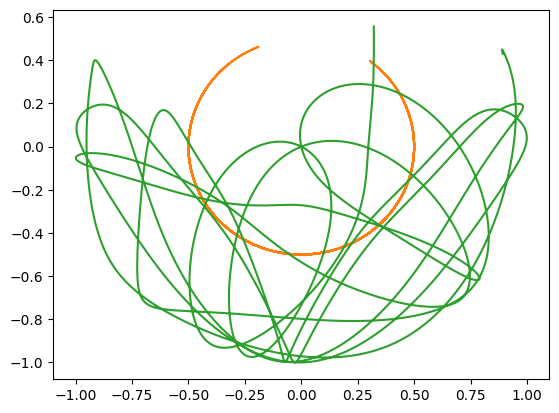

In [88]:
t = np.linspace(0, 10, 10000)
p = integrate_pendulum(n=2, times=t,initial_positions=100)
x, y = get_xy_coords(p)
plt.plot(x, y);

Initial angular positions: [42, 84, 126]


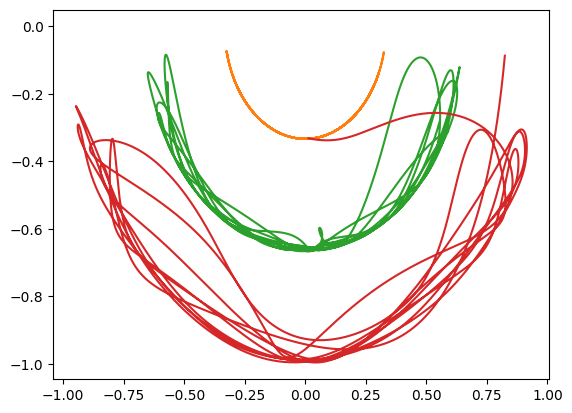

In [89]:
p = integrate_pendulum(n=3, times=t,initial_positions=42)
x, y = get_xy_coords(p)
plt.plot(x, y);

In [21]:
def animate_pendulum(n,initial_positions=100):
    t = np.linspace(0, 10, 200)
    p = integrate_pendulum(n, t, initial_positions=initial_positions)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [20]:
for i in range(3,6):
    anim = animate_pendulum(i)
    anim.save(f'videos/triple-pendulum{i}.mp4', extra_args=['-vcodec', 'libx264'])
    video = Video(f"videos/triple-pendulum{i}.mp4", embed=True)
    display(video)

Initial angular positions: [100, 200, 300]


Initial angular positions: [100, 200, 300, 400]


Initial angular positions: [100, 200, 300, 400, 500]


In [92]:
def animate_pendulum_multiple(n, n_pendulums=3, perturbation=1E-6, track_length=15):
    oversample = 3
    track_length *= oversample
    
    t = np.linspace(0, 10, oversample * 200)
    p = [integrate_pendulum(n, t, initial_positions=100 + i * perturbation / n_pendulums)
         for i in range(n_pendulums)]
    positions = np.array([get_xy_coords(pi) for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    track_segments = np.zeros((n_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow')
    tracks.set_array(np.linspace(0, 1, n_pendulums))
    ax.add_collection(tracks)
    
    points, = plt.plot([], [], 'ok')
    
    pendulum_segments = np.zeros((n_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((n_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((n_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim
    
anim = animate_pendulum_multiple(3)
anim.save('videos/pendeleum-butterfly.mp4', extra_args=['-vcodec', 'libx264'])
video = Video("videos/pendeleum-butterfly.mp4", embed=True)
display(video)

Initial angular positions: [100.0, 200.0, 300.0]
Initial angular positions: [100.00000033333333, 200.00000066666666, 300.000001]
Initial angular positions: [100.00000066666666, 200.00000133333333, 300.000002]
